In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
import pickle
from scipy import stats
from helper import *

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import SelectFromModel, SelectPercentile, RFECV, mutual_info_classif, chi2, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from genetic_selection import GeneticSelectionCV

In [7]:
'''
See imputing notes from data_nonet_analysis.ipynb
'''
def impute_MARs(vars, df):

    for v in vars:
        col = df[v]
        if v == 'TB2':
            for idx, i in enumerate(col):
                if i == 5:
                    df.at[idx, 'TB2_4_TEXT'] = -1
                    df.at[idx, 'TB3'] = 1
                    df.at[idx, 'TB4'] = 0
        if v == 'TB3':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB4'] = 0
        if v == 'TB5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB6'] = -1
                    df.at[idx, 'TB7'] = 1
                    df.at[idx, 'TB8'] = 0
        if v == 'TB7':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB8'] = 0
        if v == 'TB9':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB10'] = -1
                    df.at[idx, 'TB11'] = 1
                    df.at[idx, 'TB12'] = 0
        if v == 'TB11':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB12'] = 0
        if v == 'AL1':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL1_4_TEXT'] = -1
                    df.at[idx, 'AL2_1_TEXT'] = -1
                    df.at[idx, 'AL3_1_TEXT'] = -1
                    df.at[idx, 'AL4'] = 1
                    df.at[idx, 'AL5'] = 0
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
                elif i == 3:
                    df.at[idx, 'AL1_4_TEXT'] = -2
        if v == 'AL2':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL2_1_TEXT'] = -2
        if v == 'AL3':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL3_1_TEXT'] = -2
        if v == 'AL5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
        if v == 'AL6A':
            for idx, i in enumerate(col):
                if pd.isnull(df.loc[idx, v]) and not pd.isnull(df.loc[idx, 'AL6B']):
                    df.at[idx, v] = df.at[idx, 'AL6B']
        if v == 'ID1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ID2'] = -1
                    for j in range(3,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID17':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(18,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ND1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ND2'] = -1
        if v == 'OD1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD2'] = 0
        if v == 'OD6':
            for idx, i in enumerate(col):
                if i == 2:
                    for j in range(7,12):
                        df.at[idx, f'OD{j}'] = 0
        if v == 'OD8':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD9'] = 0
        if v == 'OD10':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD11'] = 0
        if v == 'CJ3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,8):
                        df.at[idx, f'CJ{j}'] = -1
        if v == 'DM12':
            for idx, i in enumerate(col):
                if i != 1:
                    df.at[idx, 'DM13'] = -1

    vars_mixed = ['DM1','TB2_4_TEXT','TB6','TB10','AL1_4_TEXT','AL2_1_TEXT','AL3_1_TEXT','ID2','ND2']
    for v in vars_mixed:
        col = df[v]
        if v[-4:] == 'TEXT':  # e.g., modify TB2 column instead of TB2_4_TEXT
            v = v.split('_')[0]
        for idx, i in enumerate(col):
            if 0 <= i <= 14:    df.at[idx, v] = 0  # children
            elif 15 <= i <= 24: df.at[idx, v] = 1  # youth
            elif 25 <= i <= 64: df.at[idx, v] = 2  # adult
            elif i >= 65:       df.at[idx, v] = 3  # senior
            elif i == -1:       df.at[idx, v] = -1  # never
            elif i == -2 or (np.isnan(i) and df.at[idx, v] == 4):       df.at[idx, v] = np.nan  # don't know

    v = 'SC1'  # numerical variable (# of years)
    col = df[v]
    for idx, i in enumerate(col):
        if i < 0.5:    df.at[idx, v] = 0  # less than 6 months
        elif 0.5 <= i < 1:  df.at[idx, v] = 1  # 
        elif 1 <= i < 2:    df.at[idx, v] = 2  #
        elif 2 <= i < 5:    df.at[idx, v] = 3  #
        elif 5 <= i < 10:    df.at[idx, v] = 4  #
        elif i >= 10:       df.at[idx, v] = 5  # more than 10 years

    return df

In [8]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
    score=None, baseline=1
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(7, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    if score is not None:
        axes.plot([], [], ' ', label=f"CV acc/baseline acc: {round(score, 3)}/{round(baseline, 3)}")

    axes.legend(loc="lower right")

    fig.tight_layout()

    return plt

In [9]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):
    # param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=LeaveOneOut())
    # clf.fit(standard_scale(X), y)

    # return clf.best_estimator_, clf.best_score_

    clf = LogisticRegression()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def pruned_decision_trees_tuned(X, y):
    # param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
    # clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = DecisionTreeClassifier()
    loocv_scores = cross_val_score(clf, X, y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def svm_tuned(X, y):
    # param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # clf = GridSearchCV(estimator=SVC(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = SVC()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)


def plot_LC_tuned(X, y, cohort, drug, fgroup, savefile=None, baseline=1, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

    title = "Learning Curves (logistic regression)"
    estimator, lg_score = log_regression_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=lg_score, baseline=baseline
    )

    title = "Learning Curves (decision tree)"
    estimator, dt_score = pruned_decision_trees_tuned(X, y)
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=dt_score, baseline=baseline
    )

    title = "Learning Curves (SVM)"
    estimator, svm_score = svm_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=svm_score, baseline=baseline
    )

    suptitle = f'Cohort {cohort}: {drug} use, features {fgroup}'
    if len(suptitle) > 120:     suptitle = '-\n'.join(suptitle[j:j+120] for j in range(0,len(suptitle), 120))  # break line if title too long
    fig.suptitle(suptitle)
    fig.tight_layout()
    # if savefile is None:
    #     plt.savefig(f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-{fgroup}_learningCurve.pdf', facecolor='white')
    # else:
    #     plt.savefig(savefile, facecolor='white')

    return lg_score, dt_score, svm_score

In [10]:
datapath = 'data/original/pre-imputed/'

C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
C1W1nonet_vars = list(C1W1nonet_df.columns)

C2W1nonet_df = pd.read_csv(datapath + 'C2W1_nonnetwork_preimputed.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')
C2W1nonet_vars = list(C2W1nonet_df.columns)

C1W1nonet_vars == C2W1nonet_vars

True

In [11]:
for cohort in [2]:  # 1, 2, or '1+2'
    for drug in ['marijuana']:  # 'marijuana' or 'meth'

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])
        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # for gname, fsubs in fsubs_nonnet.items():
        #     X = X_imp
        #     plot_LC_tuned(X, y, cohort, drug, gname, baseline=baseline)

In [7]:
print(f'Cohort {cohort}, {drug}, initial shape (n_samples, n_features): {X_imp.shape}')

Cohort 2, marijuana, initial shape (n_samples, n_features): (76, 154)


Note: Unless specified, all data X, y in each cell of this notebook is from Cohort 2 on marijuana

<img src="images/feature selection.png" alt="drawing" width="500"/>

### Wrapper Approach

#### Exhaustive feature selection

Very expensive, only find best pair of features

In [23]:
efs = ExhaustiveFeatureSelector(LogisticRegression(),
                                min_features=1,
                                max_features=2,
                                scoring='accuracy',
                                print_progress=True,
                                cv=LeaveOneOut())

efs = efs.fit(X_imp, y)

Features: 11935/11935

In [26]:
print(efs.best_idx_)
print(efs.best_score_)

(38, 78)
0.75


Remark: with the right combination of features, the issue of weights all zero and overlapping learning curves can be fixed. That is, the LOOCV accuracy CAN go higher than the baseline.

It is therefore more important to select the right features than to hypertune.

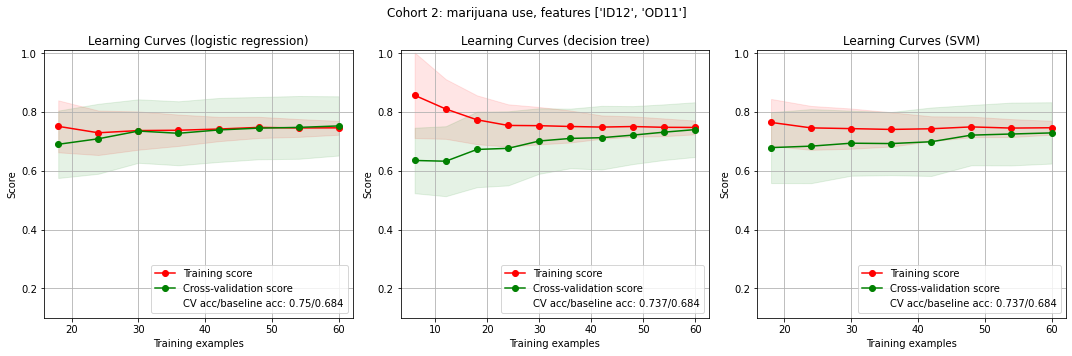

In [40]:
X = X_imp[:, list(efs.best_idx_)]
best_feature_names = [list(Xenc_df.columns)[i] for i in efs.best_idx_]
lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, best_feature_names, baseline=baseline)

In [48]:
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, cv=LeaveOneOut())
print(np.mean(scores))
print(scores)

0.75
[1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0.]


In [50]:
cv_results = cross_validate(clf, X, y, cv=LeaveOneOut(), return_estimator=True)
for i, model in enumerate(cv_results['estimator']):
    print(f"score = {scores[i]}; weights = {model.coef_}")  # non-zero weights --> clf is actually learning

score = 1.0; weights = [[ 0.92111317 -1.03716679]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 0.0; weights = [[ 0.89428731 -1.10200257]]
score = 1.0; weights = [[ 0.92111317 -1.03716679]]
score = 0.0; weights = [[ 0.89428731 -1.10200257]]
score = 1.0; weights = [[ 0.87788451 -1.0040743 ]]
score = 1.0; weights = [[ 0.80634584 -1.0315409 ]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 0.0; weights = [[ 0.96854142 -1.02639444]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 1.0; weights = [[ 0.93857355 -1.0227853 ]]
score = 1.0; weights = [[ 0.92111317 -1.03716679]]
score = 1.0; weights = [[ 0.92111317 -1.03716679]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 1.0; weights = [[ 0.96200504 -1.03948207]]
score = 1.0; weights = [[ 0.92111317 -1.03716679]]
score = 1.0; weights = [[ 0.92499847 -1.07593924]]
score = 0.0; weights = [[ 1.046

#### Genetic Algorithm

Decision tree

In [48]:
X = X_imp

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
clf = DecisionTreeClassifier()
model = GeneticSelectionCV(
    clf, cv=cv, verbose=0,
    scoring="accuracy", max_features=None,
    n_population=300, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=40,
    crossover_independent_proba=0.1,
    mutation_independent_proba=0.05,
    tournament_size=3, n_gen_no_change=10,
    caching=False, n_jobs=5)
model = model.fit(X, y)

In [49]:
# print(model.support_)
print(sum(model.support_), len(model.support_))
print(Xenc_df.columns[model.support_])

5 154
Index(['DA1_4', 'OD2', 'AC3D', 'AC5B', 'AC7C'], dtype='object')


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

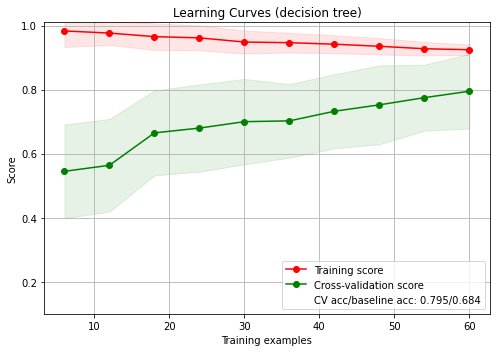

In [50]:
X_new = X[:, model.support_]

title = 'Learning Curves (decision tree)'
dt_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(dt_scores), baseline=baseline
)

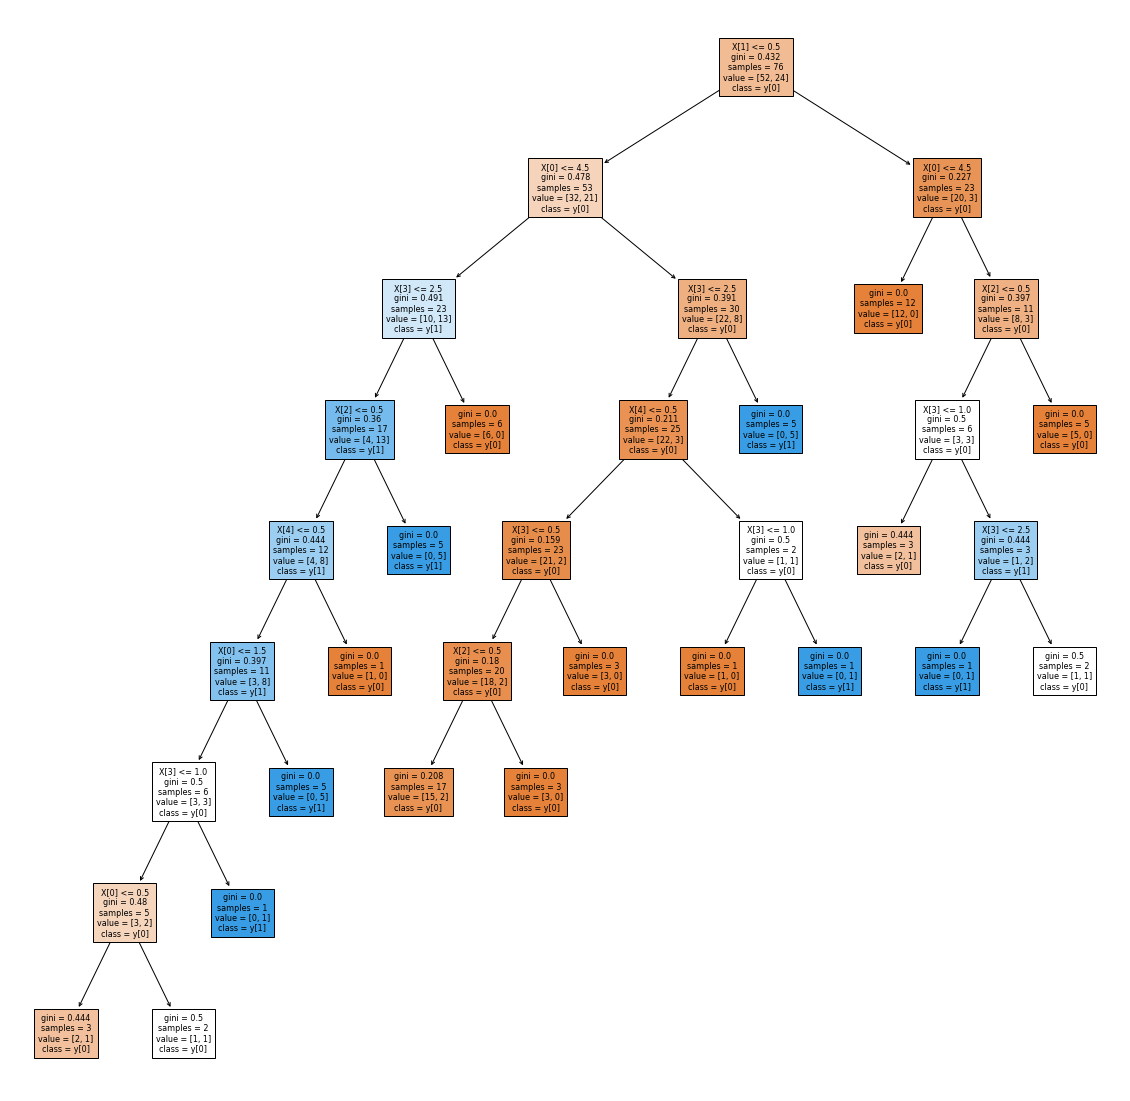

In [51]:
plt.figure(figsize=(20,20))
plot_tree(clf.fit(X_new, y),filled=True,fontsize=8,class_names=True)
plt.show()

All models

logistic regression: ['SC3', 'SC4', 'SC5', 'TB12', 'AL3', 'ID2', 'ID3', 'ID6', 'ID9', 'ID10', 'ID11', 'ID12', 'ND1', 'ND9', 'DA1_3', 'DA1_5', 'DA1_6', 'DA2_6', 'OD11', 'TX1_1', 'TX1_2', 'TX1_3', 'AC3C', 'AC4B', 'AC5A', 'AC9A', 'AC10', 'DM9', 'DM23', 'DM13_-1.0']
decision tree: ['TB7', 'ID1', 'DA1_4', 'OD2', 'OD9', 'TX2_4', 'AC5B', 'DM10_1.0', 'DM10_4.0']
SVM: ['SC3', 'AL5', 'ID10', 'DA1_4', 'OD10', 'OD11', 'AC8B']
linear SVM: ['TB11', 'AL4', 'AL5', 'ID1', 'ID4', 'ID6', 'ID15', 'ID16', 'ID20', 'ND1', 'OD2', 'OD11', 'TX1_6', 'TX2_5', 'AC1A', 'AC2A', 'AC8A']


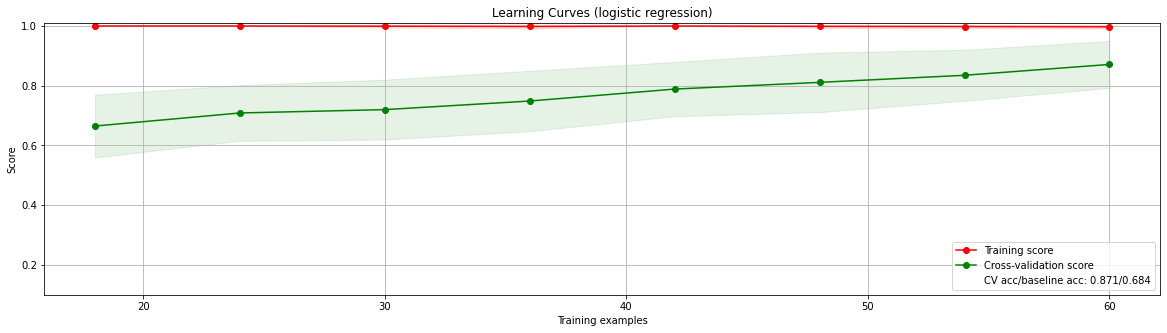

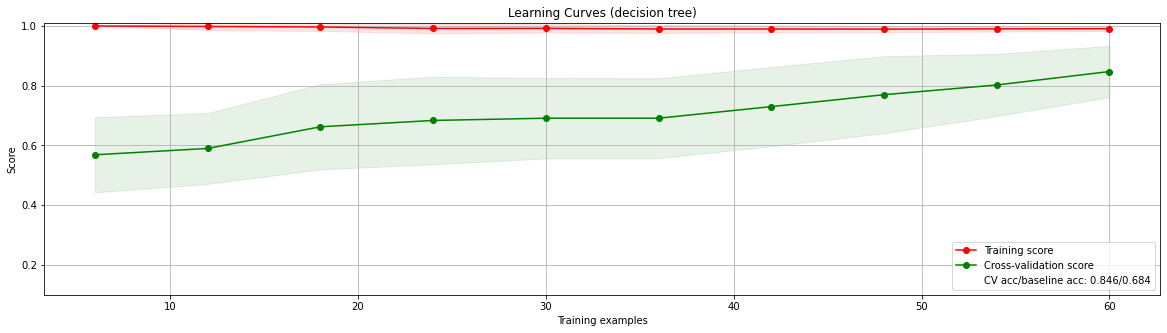

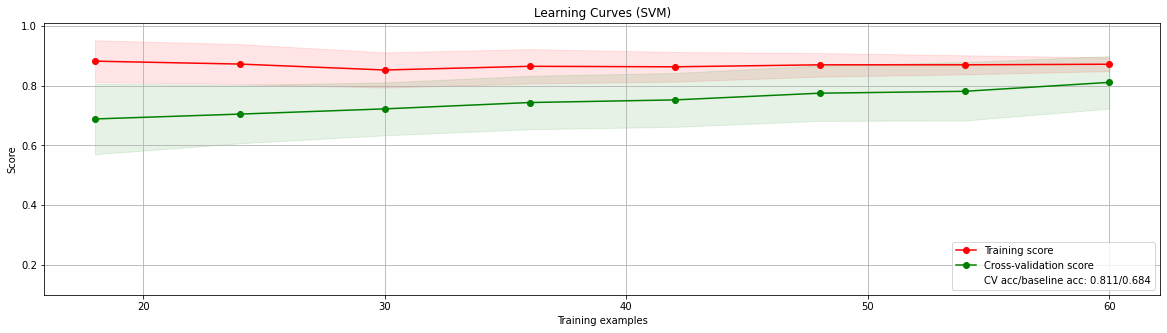

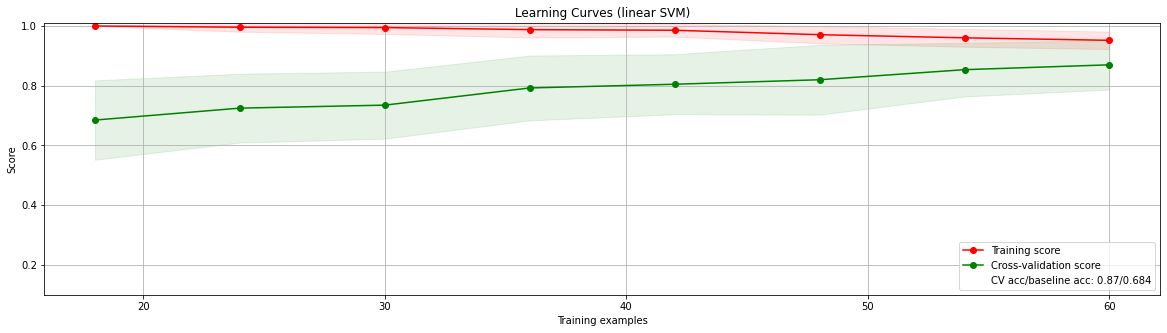

In [8]:
@ignore_warnings(category=ConvergenceWarning)
def genetic_alg(clf_dict):

    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
    for clf_name, clf in clf_dict.items():
        X = standard_scale(X_imp) if clf_name in ['logistic regression', 'SVM', 'linear SVM'] else X_imp
        model = GeneticSelectionCV(
            clf, cv=cv, verbose=0,
            scoring="accuracy", max_features=None,
            n_population=300, crossover_proba=0.5,
            mutation_proba=0.2, n_generations=40,
            crossover_independent_proba=0.1,
            mutation_independent_proba=0.05,
            tournament_size=3, n_gen_no_change=10,
            caching=False, n_jobs=5)
        model = model.fit(X, y)

        X_new = X[:, model.support_]
        print(f'{clf_name}: {list(Xenc_df.columns[model.support_])}')

        title = f'Learning Curves ({clf_name})'
        scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
        plot_learning_curve(
            clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(scores), baseline=baseline
        )

genetic_alg({'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'SVM': SVC(),
            'linear SVM': LinearSVC()})

<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

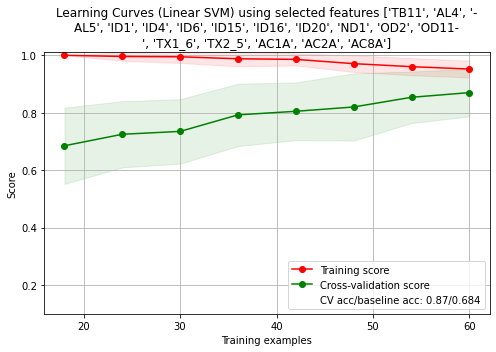

In [45]:
selected_features = ['TB11', 'AL4', 'AL5', 'ID1', 'ID4', 'ID6', 'ID15', 'ID16', 'ID20', 'ND1', 'OD2', 'OD11', 'TX1_6', 'TX2_5', 'AC1A', 'AC2A', 'AC8A']
X_new = standard_scale(X_imp[:, [Xenc_df.columns.get_loc(f) for f in selected_features]])

clf = LinearSVC()
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
title = f'Learning Curves (Linear SVM) using selected features {selected_features}'
if len(title) > 70:     title = '-\n'.join(title[j:j+70] for j in range(0,len(title), 70))  # break line if title too long
scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(scores), baseline=baseline
)

In [18]:
cv_results = cross_validate(clf, X_new, y, cv=cv, return_estimator=True)
print(f'{np.mean(scores)}')
for i, model in enumerate(cv_results['estimator'][:1]):
    print(f"score = {scores[i]}; weights = {model.coef_}")  # non-zero weights --> clf is actually learning

0.87
score = 0.9375; weights = [[ 0.12025376  0.39448281 -0.3726347  -0.10353666 -0.62425857  0.73038404
  -0.12899111  0.85552781 -0.07917844  0.72283604 -0.72687274 -0.34610663
   0.54619049 -0.2543328  -0.57820121  0.21674955  0.73207715]]


Save figs for all

In [80]:
@ignore_warnings(category=ConvergenceWarning)
def genetic_alg(clf_dict, X_raw, y, cohort, drug, baseline, cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)):

    results_dict = {}
    for clf_name, clf in clf_dict.items():
        X = standard_scale(X_raw) if clf_name in ['logistic regression', 'SVM', 'linear SVM'] else X_raw
        model = GeneticSelectionCV(
            clf, cv=cv, verbose=0,
            scoring="accuracy", max_features=None,
            n_population=300, crossover_proba=0.5,
            mutation_proba=0.2, n_generations=40,
            crossover_independent_proba=0.1,
            mutation_independent_proba=0.05,
            tournament_size=3, n_gen_no_change=10,
            caching=False, n_jobs=5)
        model = model.fit(X, y)

        X_new = X[:, model.support_]
        selected_features = list(Xenc_df.columns[model.support_])


        title = f'Learning Curves ({clf_name}) using selected features {selected_features}'
        if len(title) > 70:     title = '-\n'.join(title[j:j+70] for j in range(0,len(title), 70))  # break line if title too long
        scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
        results_dict[clf_name] = {'cv_score': np.mean(scores), 'features': selected_features}
        plot_learning_curve(
            clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(scores), baseline=baseline
        )
        plt.savefig(f'plots/analysis/learning_curve/feature_selection/GA/C{cohort}-{drug}-{clf_name}_learningCurve.pdf', facecolor='white')

    return results_dict

In [ ]:
clf_dict = {'logistic regression': LogisticRegression(),
            'decision tree': DecisionTreeClassifier(),
            'linear SVM': LinearSVC()}
cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
results = {}

for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])
        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        results[f'{cohort}-{drug}'] = genetic_alg(clf_dict, X_imp, y, cohort, drug, baseline=baseline, cv=cv)

with open('saved-vars/GA_feature-selection.pkl', 'wb') as file:
    pickle.dump(results, file)

Nested CV

Although learning curves in all folds show improvement over training samples, the final (mean) accuracy on outer test set is lower than baseline

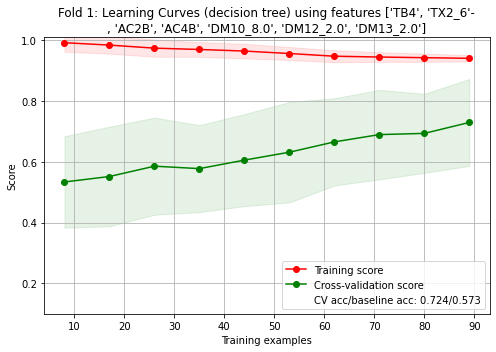

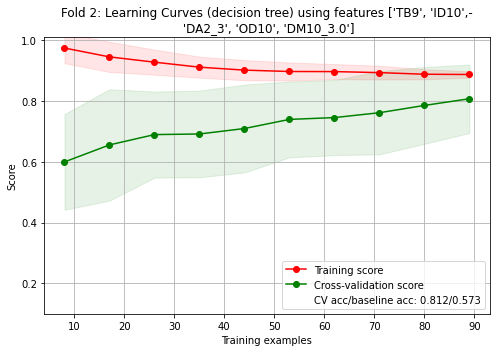

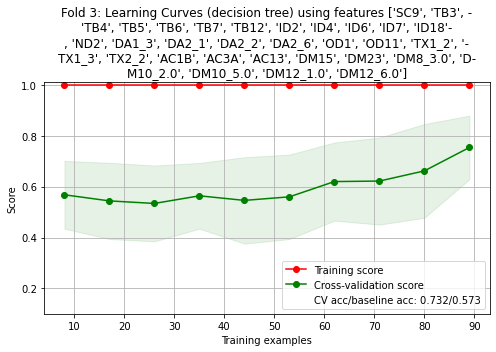

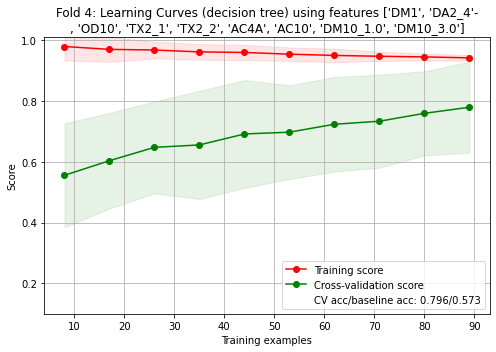

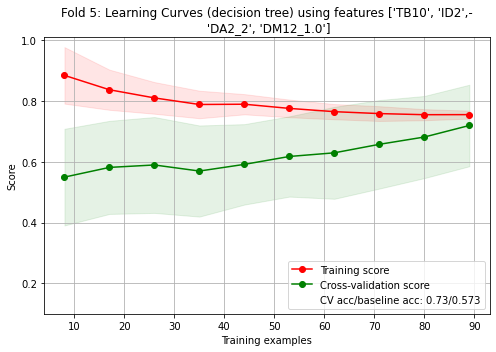

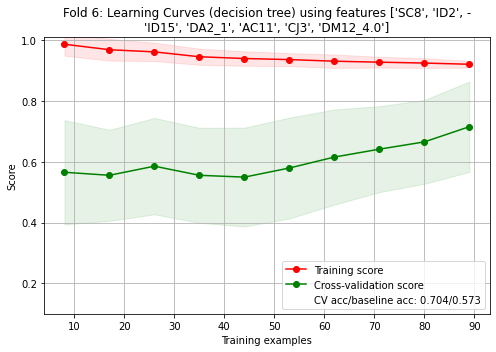

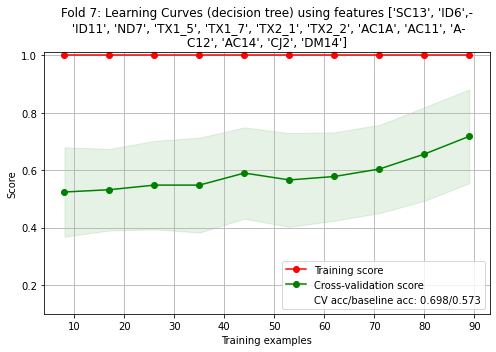

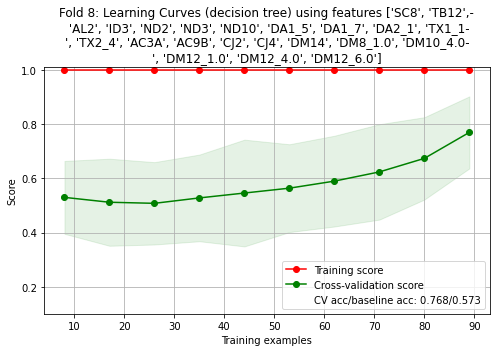

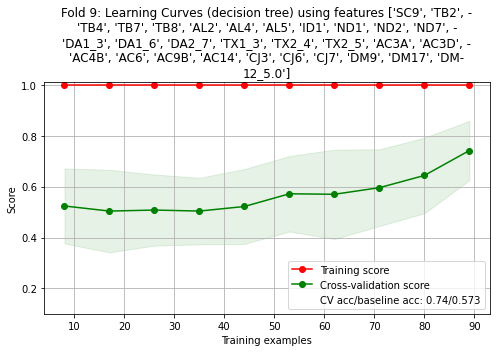

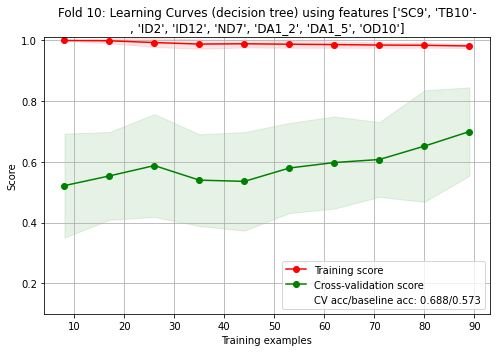

In [20]:
# C1+2, meth
X = X_imp

cv_outer = KFold(n_splits=10)
cv_inner = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)

fold_list = []
i = 0
for train_idx, test_idx in cv_outer.split(X):
    i += 1
    X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
    clf = DecisionTreeClassifier()
    model = GeneticSelectionCV(
        clf, cv=cv_inner,
        scoring="accuracy", max_features=None,
        n_population=300, crossover_proba=0.5,
        mutation_proba=0.2, n_generations=40,
        crossover_independent_proba=0.1,
        mutation_independent_proba=0.05,
        tournament_size=3, n_gen_no_change=10,
        n_jobs=5)
    model = model.fit(X_train, y_train)

    X_train_new, X_test_new = X_train[:, model.support_], X_test[:, model.support_]
    selected_features = list(Xenc_df.columns[model.support_])
    title = f'Fold {i}: Learning Curves (decision tree) using features {selected_features}'
    if len(title) > 70:     title = '-\n'.join(title[j:j+70] for j in range(0,len(title), 70))  # break line if title too long    
    scores = cross_val_score(clf, X_train_new, y_train, scoring='accuracy', cv=cv_inner)
    plot_learning_curve(
        clf, title, X_train_new, y_train, ylim=(0.1, 1.01), cv=cv_inner, n_jobs=4, scoring="accuracy", score=np.mean(scores), baseline=baseline
    )

    predictions = clf.fit(X_train_new, y_train).predict(X_test_new)
    fold_list.append({'prediction': predictions, 'label': y_test, 'accuracy': np.mean(predictions==y_test)})

In [21]:
accs = [fold['accuracy'] for fold in fold_list]
print(f'Final accuracy = {np.mean(accs)} +- {np.std(accs)}')
print(accs, )

Final accuracy = 0.5272727272727273 +- 0.16663911618021238
[0.7272727272727273, 0.2727272727272727, 0.36363636363636365, 0.5454545454545454, 0.7272727272727273, 0.36363636363636365, 0.7272727272727273, 0.36363636363636365, 0.5454545454545454, 0.6363636363636364]


In [22]:
fold_list[0]

{'prediction': array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]),
 'label': array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.]),
 'accuracy': 0.7272727272727273}

#### RFE

As expected, RFE (greedy, local) is much worse than GA (non-greedy, global)

In [52]:
X = X_imp

cv=ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1, cv=cv, scoring="accuracy", min_features_to_select=5
)
model = rfecv.fit(X, y)

153 154
Index(['SC3', 'SC4', 'SC5', 'SC6', 'SC8', 'SC9', 'SC13', 'DM1', 'TB1', 'TB2',
       ...
       'DM10_9.0', 'DM12_1.0', 'DM12_2.0', 'DM12_4.0', 'DM12_5.0', 'DM12_6.0',
       'DM13_-1.0', 'DM13_2.0', 'DM13_4.0', 'DM13_5.0'],
      dtype='object', length=153)


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

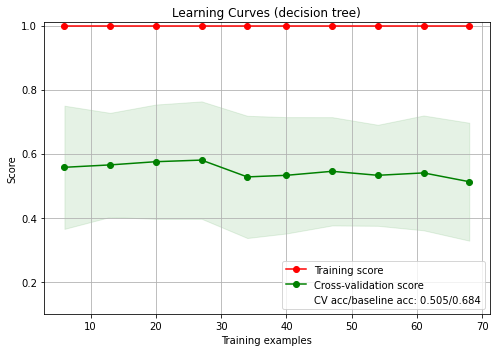

In [53]:
print(sum(model.support_), len(model.support_))
print(Xenc_df.columns[model.support_])

X_new = X[:, model.support_]

title = 'Learning Curves (decision tree)'
dt_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(dt_scores), baseline=baseline
)

### Intrinsic Approach

#### Logistic Regression

Use feature selection that is built-in during the training of clf. That is, only keep features with $|weight|\ge threshold$. By default, threshold is mean of the $|weight|$'s

Old: (76, 154) vs. New: (76, 61)


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

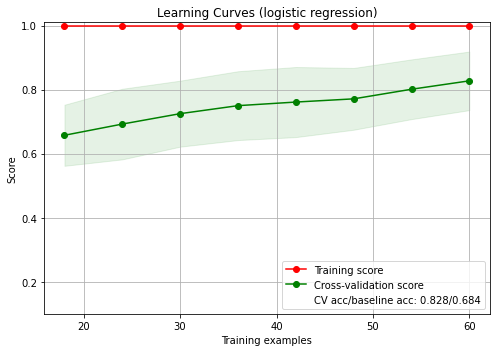

In [35]:
X = standard_scale(X_imp)
clf = LogisticRegression()
model = SelectFromModel(clf.fit(X, y), prefit=True)  # only keep features with |weight| >= threshold. By default, threshold is mean of the |weight|'s
X_new = model.transform(X)
print(f'Old: {X_imp.shape} vs. New: {X_new.shape}')

title = 'Learning Curves (logistic regression)'
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
lg_score = np.mean(cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv))
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=lg_score, baseline=baseline
)

#### Decision Tree

feature selection from single tree

Old: (76, 154) vs. New: (76, 12)
Index(['SC5', 'TB1', 'ID6', 'ND2', 'ND7', 'DA2_5', 'OD10', 'TX1_5', 'CJ5',
       'DM8_4.0', 'DM10_6.0', 'DM12_5.0'],
      dtype='object')


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

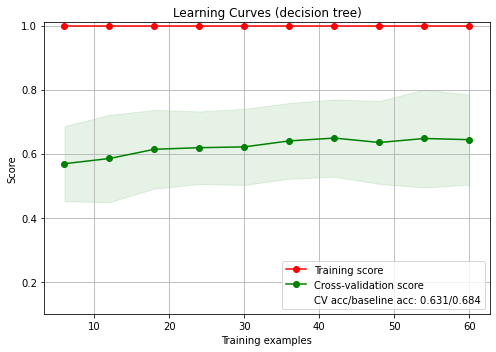

In [40]:
X = X_imp
clf = DecisionTreeClassifier(criterion='gini')
model = SelectFromModel(clf.fit(X, y), prefit=True)
# model = SelectFromModel(clf, prefit=False).fit(X, y)
X_new = model.transform(X)
print(f'Old: {X_imp.shape} vs. New: {X_new.shape}')
print(Xenc_df.columns[model.get_support()])

title = 'Learning Curves (decision tree)'
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
dt_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(dt_scores), baseline=baseline
)

In [20]:
'''
The importance of a feature is computed as the (normalized) total reduction of the criterion (e.g., Gini) brought by that feature.
'''
print(list(clf.feature_importances_.flatten()),)

[0.0, 0.05219780219780222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04956114398422094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06514876632801166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15930309007232074, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1233730395014865, 0.05369123931623928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08897352647352649, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07873607873607874, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0811965811965812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05413105413105414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058360042735042784, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13532763532763536, 0.0, 0.0, 0.0, 0.0, 0.0]


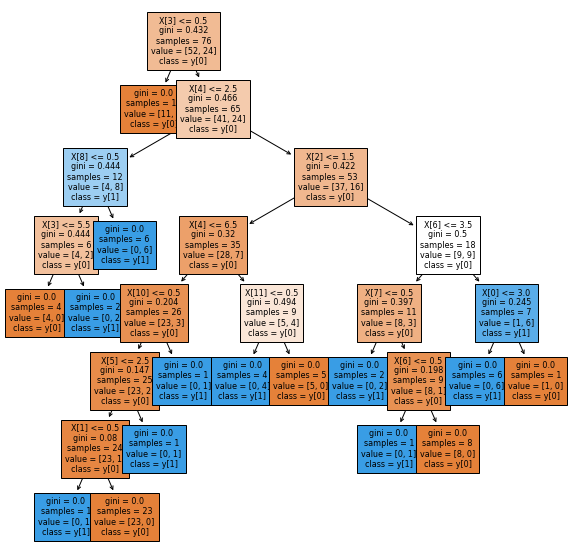

In [21]:
plt.figure(figsize=(10,10))
plot_tree(clf.fit(X_new, y),filled=True,fontsize=8,class_names=True)
plt.show()

feature selection from forest

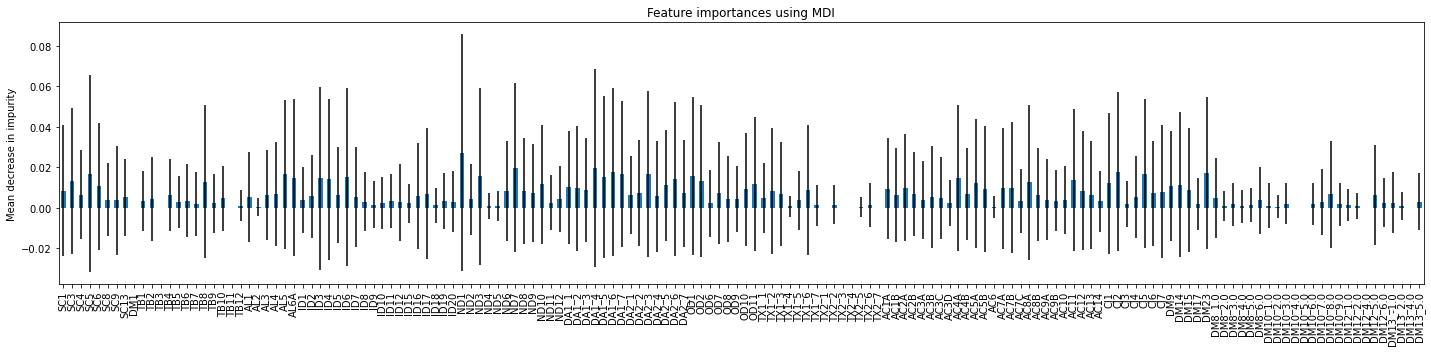

In [56]:
feature_names = list(Xenc_df.columns)
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
# print(list(forest_importances), )

fig, ax = plt.subplots(figsize=(20,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

['DM14', 'ND10', 'CJ1', 'OD11', 'AC5A', 'AC8A', 'DM23', 'ND1', 'AC4A', 'CJ5', 'ID6', 'DA1_4', 'ID4', 'ID3', 'DA1_5', 'AL6A', 'AL5', 'DA1_6', 'DA1_7', 'DA2_3', 'ND3', 'CJ2', 'TB8', 'DA2_6', 'AC11', 'ND7', 'OD1', 'SC5', 'SC3', 'OD2']


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

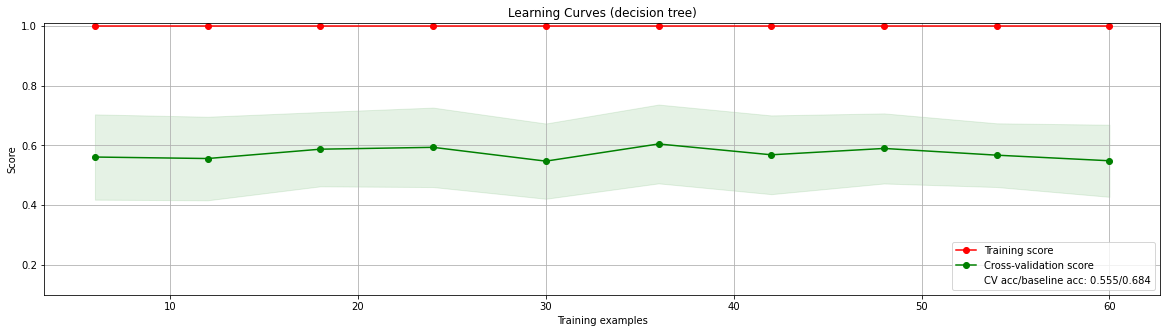

In [57]:
n_top = 30
X_new = X[:, np.argpartition(forest_importances, -n_top)[-n_top:]]
print(list(Xenc_df.columns[np.argpartition(forest_importances, -n_top)[-n_top:]]), )

clf = DecisionTreeClassifier(criterion='gini')
title = 'Learning Curves (decision tree)'
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
dt_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(dt_scores), baseline=baseline
)

#### SVM

<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

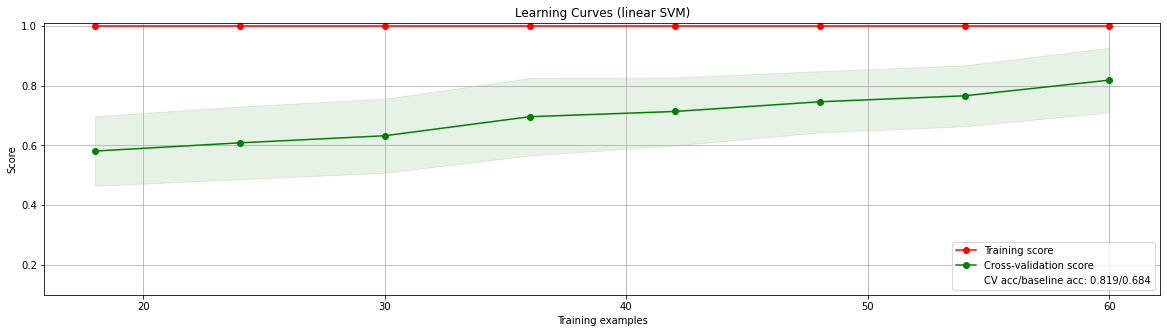

In [42]:
X = standard_scale(X_imp)
clf = LinearSVC()
model = SelectFromModel(clf.fit(X, y), prefit=True)  # only keep features with |weight| >= threshold. By default, threshold is mean of the |weight|'s
X_new = model.transform(X)

title = 'Learning Curves (linear SVM)'
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
svm_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(svm_scores), baseline=baseline
)

In [73]:
cv_results = cross_validate(clf, X_new, y, cv=LeaveOneOut(), return_estimator=True)
print(f'{np.mean(svm_scores)}')
for i, model in enumerate(cv_results['estimator'][:1]):
    print(f"score = {svm_scores[i]}; weights = {model.coef_}")  # non-zero weights --> clf is actually learning

0.9736842105263158
score = 1.0; weights = [[-2.18829769e-01 -1.14672286e-01  1.13453223e-01  1.46052241e-01
  -9.60026602e-02  1.61869672e-01 -1.09950273e-01  1.24603946e-01
   1.57598781e-01  2.34925332e-01 -2.89471826e-01  2.70185734e-01
  -8.87825108e-02  3.36996547e-01 -4.39045328e-03  9.81059146e-02
   1.94229222e-01  8.97342107e-02 -1.71409225e-01  2.00542081e-01
  -1.18521427e-01 -1.95085002e-01  2.42600432e-01 -4.20633352e-01
  -1.79770523e-01  1.80815938e-01  1.42333045e-01  2.42780113e-01
  -1.31563371e-01 -1.24644854e-01  2.10513833e-02 -2.20343920e-02
  -3.33747339e-01 -1.24142894e-01  5.55326305e-02  1.14445426e-01
  -1.46911291e-01 -1.29085905e-01  2.11377741e-04  2.00030359e-01
  -6.06514018e-02 -2.41391299e-01  2.63038374e-01 -1.78939151e-01
   1.45116158e-02  1.91447502e-01  1.99497467e-01 -2.05438215e-01
   1.25993699e-01 -1.90842791e-01  1.32111436e-01  8.26671507e-02
  -1.17617406e-01  2.75893195e-01 -2.62028430e-02  1.20670134e-01
  -2.68962347e-02  8.09560866e-02 

### Filter Approach

SVM vs LinearSVM

Use features from Cramer's V index ranking

We see that SVM with linear kernel performs slightly better than with 'rbf' kernel

<img src="images/SVM.png" alt="drawing" width="900"/>

In [20]:
features = ['AC7B', 'ND1', 'ND2', 'OD2', 'ND7', 'OD1', 'ID9', 'ID12', 'ID4', 'OD10', 'DA1_5', 'ID6']
features = ['AC7B', 'ND1', 'ND2', 'OD2', 'ND7', 'OD1', 'ID9', 'ID12', 'ID4', 'OD10', 'DA1_5', 'ID6',
        'ID7', 'AC4A', 'ND10', 'DM9', 'CJ7', 'ID3', 'ID8', 'ID11', 'TB10', 'CJ6', 'ID2', 'ID16', 'DA1_4', 'SC3', 'DM14', 'TB8', 'SC4', 'OD11']

X = X_imp[:, [Xenc_df.columns.get_loc(f) for f in features]]
linSVM_score = np.mean(cross_val_score(LinearSVC(), standard_scale(X), y, cv=LeaveOneOut()))
SVM_score = np.mean(cross_val_score(SVC(kernel='rbf'), standard_scale(X), y, cv=LeaveOneOut()))

print(f'Linear SVM: {linSVM_score}; SVM: {SVM_score}')

Linear SVM: 0.7368421052631579; SVM: 0.7236842105263158


#### SVM

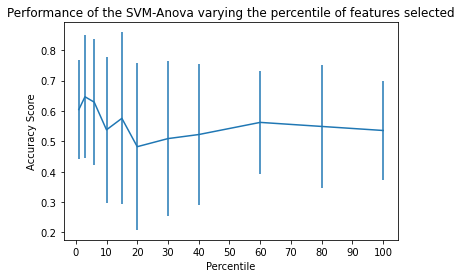

In [30]:
clf = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("svc", LinearSVC()),
    ]
)

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)  # Percents of features to keep

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_imp, y, cv=15)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

Best parameter (CV score=0.688):
{'anova__percentile': 3} 0.6875
Index(['ID3', 'ID6', 'ID15', 'ND1', 'OD2'], dtype='object')


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

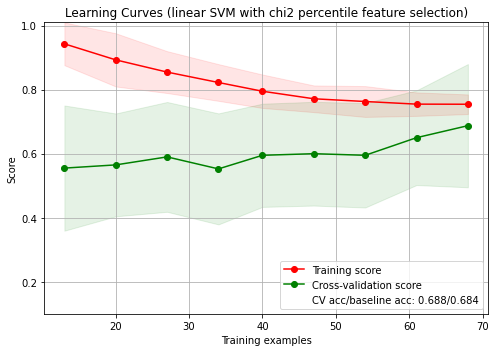

In [30]:
X = X_imp

pipe = Pipeline(steps=[("anova", SelectPercentile(chi2)), ("scaler", StandardScaler()), ("svc", LinearSVC())])

param_grid = {
    "anova__percentile": [1, 3, 6, 10, 15, 20, 30, 40],
}
cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=2)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_, search.best_score_)
print(Xenc_df.columns[search.best_estimator_['anova'].get_support()])

title = 'Learning Curves (linear SVM with chi2 percentile feature selection)'

plot_learning_curve(
    search.best_estimator_, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=search.best_score_, baseline=baseline
)

#### Decision Tree

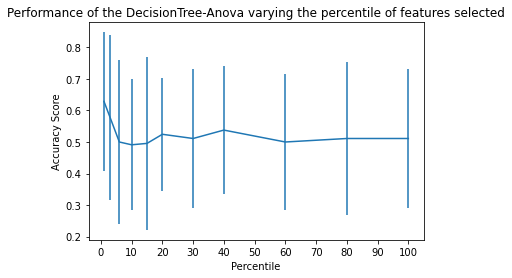

In [11]:
clf = Pipeline(
    [
        ("anova", SelectPercentile(chi2)),
        ("scaler", StandardScaler()),
        ("dec_tree", DecisionTreeClassifier()),
    ]
)

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)  # Percents of features to keep

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_imp, y, cv=15)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the DecisionTree-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")
plt.show()

Mutual info

<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

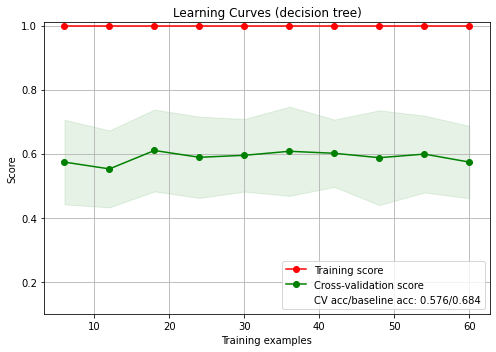

In [89]:
n_top = 30

X = X_imp
clf = DecisionTreeClassifier(criterion='gini')
f_scores = mutual_info_classif(X, y, discrete_features=True)
X_new = X[:, np.argpartition(f_scores, -n_top)[-n_top:]]

title = 'Learning Curves (decision tree)'
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
dt_scores = cross_val_score(clf, X_new, y, scoring='accuracy', cv=cv)
plot_learning_curve(
    clf, title, X_new, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=np.mean(dt_scores), baseline=baseline
)

### Unsupervised Approaches

PCA

Best parameter (CV score=0.684):
{'logistic__C': 0.0001, 'pca__n_components': 5} 0.6841666666666666


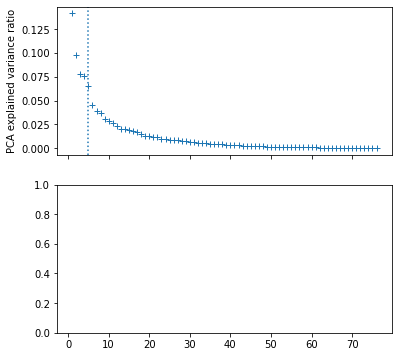

In [63]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

logistic = LogisticRegression(max_iter=10000)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_, search.best_score_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)

Best parameter (CV score=0.695):
{'pca__n_components': 5} 0.695


<module 'matplotlib.pyplot' from '/home/nthach17/anaconda3/envs/ml-basic/lib/python3.9/site-packages/matplotlib/pyplot.py'>

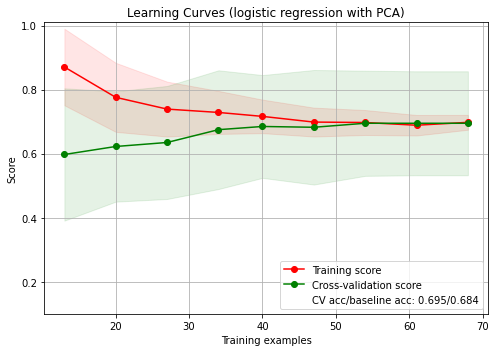

In [12]:
X = X_imp

pipe = Pipeline(steps=[("scaler", StandardScaler()), ("pca", PCA()), ("logistic", LogisticRegression())])

param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
}
cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=2)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_, search.best_score_)

title = 'Learning Curves (logistic regression with PCA)'

plot_learning_curve(
    search.best_estimator_, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=search.best_score_, baseline=baseline
)